ワークスペース内で発見: c:\Users\tokot\code\image-processing\all\CIFAR-10_data\cifar-10-batches-py
無効なモードです。'train' または 'test' を入力してください。

--- 訓練モード実行中 ---
1エポック目
 平均クロスエントロピー誤差: 2.09871031407151
 学習データに対する正答率: 0.18832000000000013
 テストデータに対する正答率: 0.2043
2エポック目
 平均クロスエントロピー誤差: 1.9688600248868473
 学習データに対する正答率: 0.23551999999999998
 テストデータに対する正答率: 0.2367
3エポック目
 平均クロスエントロピー誤差: 1.8600318906874884
 学習データに対する正答率: 0.2845200000000001
 テストデータに対する正答率: 0.2804
4エポック目
 平均クロスエントロピー誤差: 1.821849780808306
 学習データに対する正答率: 0.29204
 テストデータに対する正答率: 0.2446
5エポック目
 平均クロスエントロピー誤差: 1.7639530721672652
 学習データに対する正答率: 0.31482000000000016
 テストデータに対する正答率: 0.3124
6エポック目
 平均クロスエントロピー誤差: 1.7265418725372
 学習データに対する正答率: 0.3364400000000001
 テストデータに対する正答率: 0.302
7エポック目
 平均クロスエントロピー誤差: 1.661149337779174
 学習データに対する正答率: 0.3771200000000001
 テストデータに対する正答率: 0.3728
8エポック目
 平均クロスエントロピー誤差: 1.5950811380640748
 学習データに対する正答率: 0.4186199999999998
 テストデータに対する正答率: 0.4126
9エポック目
 平均クロスエントロピー誤差: 1.5394686971072238
 学習データに対する正答率: 0.4422799999999996
 テス

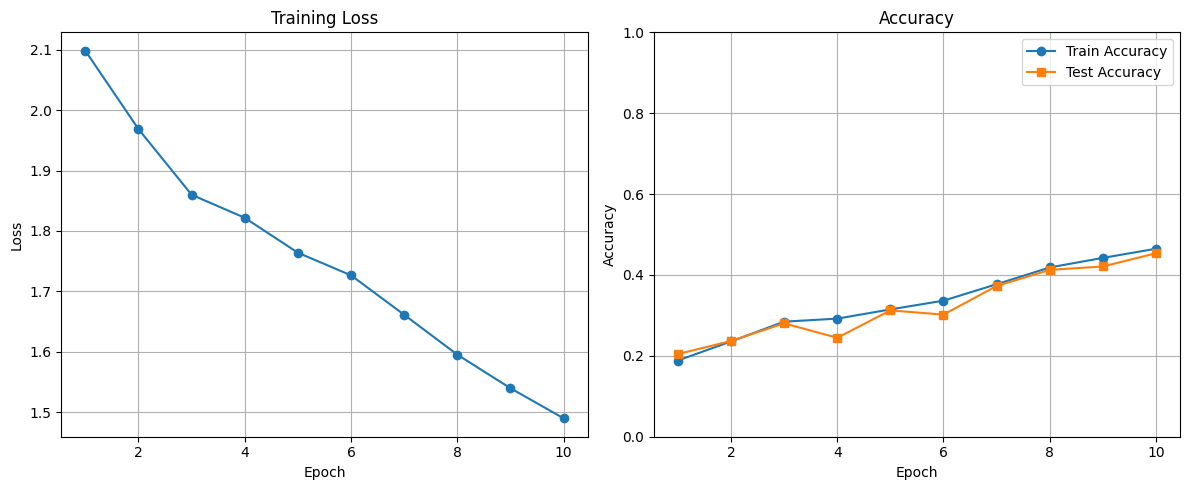

In [7]:
import os
from pathlib import Path
import urllib.request
import tarfile
import pickle
import numpy as np
import matplotlib.pyplot as plt

def ensure_cifar(data_dir="all/cifar-10-batches-py"):
    data_dir = Path(data_dir)
    # 既に指定パスに存在すれば返す
    if (data_dir / "data_batch_1").exists():
        print("CIFAR-10 データは既に存在します:", data_dir)
        return str(data_dir)

    # ワークスペース内を探索して見つかれば返す
    ws_root = Path(r"c:\Users\tokot\code\image-processing")
    for p in ws_root.rglob("data_batch_1"):
        print("ワークスペース内で発見:", p.parent)
        return str(p.parent)

    # 見つからなければダウンロードして展開
    print("CIFAR-10 が見つかりません。ダウンロードを開始します...")
    dest = ws_root / "cifar-10-python.tar.gz"
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    try:
        urllib.request.urlretrieve(url, dest)
        print("ダウンロード完了:", dest)
        with tarfile.open(dest, "r:gz") as tf:
            tf.extractall(path=ws_root)
        extracted = ws_root / "cifar-10-batches-py"
        if (extracted / "data_batch_1").exists():
            print("展開完了:", extracted)
            return str(extracted)
        raise FileNotFoundError("展開後に期待ファイルが見つかりません")
    except Exception as e:
        print("取得失敗:", e)
        raise

def load_cifar10(data_dir):
    """ (N,3072) の train/test とラベルを返す（float32 0-1 正規化） """
    train_data = None
    train_labels = []
    data_dir = str(data_dir)
    for i in range(1, 6):
        path = os.path.join(data_dir, f"data_batch_{i}")
        if not os.path.exists(path):
            raise FileNotFoundError(path)
        with open(path, "rb") as f:
            data_dict = pickle.load(f, encoding="bytes")
            if train_data is None:
                train_data = data_dict[b"data"]
            else:
                train_data = np.vstack((train_data, data_dict[b"data"]))
            train_labels.extend(data_dict[b"labels"])
    test_path = os.path.join(data_dir, "test_batch")
    with open(test_path, "rb") as f:
        data_dict = pickle.load(f, encoding="bytes")
        test_data = data_dict[b"data"]
        test_labels = data_dict[b"labels"]

    train_data = np.array(train_data, dtype=np.float32) / 255.0
    test_data = np.array(test_data, dtype=np.float32) / 255.0
    train_labels = np.array(train_labels, dtype=np.int64)
    test_labels = np.array(test_labels, dtype=np.int64)
    return train_data, train_labels, test_data, test_labels


def padding_data(train_images, test_images, pad=1):
    # (N, 3072) -> (N, 3, 32, 32) -> (N, 32, 32, 3)
    train_imgs = train_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_imgs = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    padded_train = np.pad(
        train_imgs,
        ((0, 0), (pad, pad), (pad, pad), (0, 0)),
        mode="constant",
        constant_values=0.0,
    )
    padded_test = np.pad(
        test_imgs,
        ((0, 0), (pad, pad), (pad, pad), (0, 0)),
        mode="constant",
        constant_values=0.0,
    )

    return padded_train, padded_test


def im2col(padding_data, filter_size, stride=1, pad=0):
    N, H, W, C = padding_data.shape
    
    # 出力特徴マップのサイズ計算
    out_h = (H - filter_size) // stride + 1
    out_w = (W - filter_size) // stride + 1
    
    col = np.zeros((N, out_h, out_w, filter_size, filter_size, C))

    for i in range(out_h):
        i_max = i * stride + filter_size
        for j in range(out_w):
            j_max = j * stride + filter_size
            
            # パッチを抽出
            col[:, i, j, :, :, :] = padding_data[:, i * stride:i_max, j * stride:j_max, :]
            
    # 形状を (R*R*C, N*out_h*out_w) に変換（行列乗算の形式）
    col = col.reshape(-1, filter_size * filter_size * C).T
    
    return col

def set_filter_weights():
    K = 32  # フィルタ枚数
    R = 3   # フィルタサイズ
    ch = 3  # 入力チャネル数
    input_node_count = R * R * ch 
    std_dev = np.sqrt(2.0 / input_node_count)
    # 形状は (K, R*R*ch) = (32, 27)
    W = std_dev * np.random.randn(K, R * R * ch)
    
    return W, R

def set_biases():
    K = 32  # フィルタ枚数
    b = np.random.normal(loc=0.0, scale=0.01, size=K)
    b_vector = b.reshape(-1, 1) # (K, 1) に整形
    
    return b_vector

def get_shuffled_index(arr):
    index_arr = np.arange(len(arr)) 
    np.random.shuffle(index_arr) 
    return index_arr

def get_batch(random_index): 
    # ベクトルとラベルをまとめて取得
    batch_images = padded_train_images[random_index]
    batch_labels = train_labels[random_index]
    return batch_images, batch_labels

def get_one_hot_label(batch_labels, output_layer_size):
    one_hot_labels = np.zeros((batch_labels.size, output_layer_size)) 
    one_hot_labels[np.arange(batch_labels.size), batch_labels] = 1 
    return one_hot_labels

def conv_forward(padded_data, conv_W, conv_b_vector, filter_size, stride=1):
    # 畳み込み層の順伝播 (Y = WX + B)
    N, H_prime, W_prime, C = padded_data.shape
    K, _ = conv_W.shape
    
    # Im2col変換: (N, H', W', C) -> (R*R*C, N*out_h*out_w)
    col = im2col(padded_data, filter_size, stride=stride, pad=0)
    
    # 行列積による畳み込み計算: Y = WX
    # W: (K, R*R*C) @ X: (R*R*C, N*out_h*out_w) -> Y: (K, N*out_h*out_w)
    conv_out = np.dot(conv_W, col)
    
    # バイアスの加算
    conv_out += conv_b_vector
    
    # 出力特徴マップの形状に戻す
    out_h = (H_prime - filter_size) // stride + 1 
    out_w = (W_prime - filter_size) // stride + 1 
    
    # (K, N*out_h*out_w) -> (N*out_h*out_w, K) -> (N, out_h, out_w, K)
    output = conv_out.T.reshape(N, out_h, out_w, K)
    
    return output, col

# 畳み込み層の逆伝播関数

def conv_backward(dY_4d, col):

    N, out_h, out_w, K = dY_4d.shape
    
    # dY_4d (N, out_h, out_w, K) を dY (K, N*out_h*out_w) に整形
    dY = dY_4d.transpose(3, 0, 1, 2).reshape(K, N * out_h * out_w)
        
    dW = np.dot(dY, col.T) # (K, R*R*C)
    
    db_vector = np.sum(dY, axis=1, keepdims=True) # (K, 1)
    
    return dW, db_vector

np.random.seed(777) 

def ReLU(arr):
    """課題4-1 ReLU活性化関数"""
    new_arr = np.where(arr > 0, arr, 0)
    return new_arr

def softmax(x):
    """ソフトマックス関数"""
    alpha = np.max(x, axis=-1, keepdims=True)
    exp_x = np.exp(x - alpha)
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

# --- 順伝播の実行 ---
def forward_propagation(input_data_4d, conv_W, conv_b_vector, conv_R, 
                         weight1, bias1, weight2, bias2):
    """畳み込み層 -> ReLU -> 全結合層の順伝播"""
    
    conv_output_4d, col = conv_forward(input_data_4d, conv_W, conv_b_vector, conv_R, stride=1) 
    
    hidden_layer_output_conv = ReLU(conv_output_4d)
    
    # 全結合層への入力のために平坦化
    input_vector_fc = hidden_layer_output_conv.reshape(hidden_layer_output_conv.shape[0], -1) 
    
    hidden_layer_input = np.dot(input_vector_fc, weight1.T) + bias1 
    
    hidden_layer_output = ReLU(hidden_layer_input)
    
    output_layer_input = np.dot(hidden_layer_output, weight2.T) + bias2
    final_output = softmax(output_layer_input)
    
    return  final_output, hidden_layer_input, hidden_layer_output, conv_output_4d, col

def forward_propagation_train(input_data_4d, conv_W, conv_b_vector, conv_R, 
                              weight1, bias1, weight2, bias2, ignore_number):
    
    conv_output_4d, col = conv_forward(input_data_4d, conv_W, conv_b_vector, conv_R, stride=1) 
    hidden_layer_output_conv = ReLU(conv_output_4d)
    input_vector_fc = hidden_layer_output_conv.reshape(hidden_layer_output_conv.shape[0], -1) 
    
    hidden_layer_input = np.dot(input_vector_fc, weight1.T) + bias1
    hidden_layer_output = ReLU(hidden_layer_input)
    
    # ドロップアウト適用
    for index in ignore_number:
        hidden_layer_output[:, index] = 0
        
    output_layer_input = np.dot(hidden_layer_output, weight2.T) + bias2
    final_output = softmax(output_layer_input)
    
    return final_output, hidden_layer_input, hidden_layer_output, conv_output_4d, col

def forward_propagation_test(input_data_4d, conv_W, conv_b_vector, conv_R, 
                             weight1, bias1, weight2, bias2, ignore_number):
    
    conv_output_4d, col = conv_forward(input_data_4d, conv_W, conv_b_vector, conv_R, stride=1) 
    hidden_layer_output_conv = ReLU(conv_output_4d)
    input_vector_fc = hidden_layer_output_conv.reshape(hidden_layer_output_conv.shape[0], -1) 
    
    hidden_layer_input = np.dot(input_vector_fc, weight1.T) + bias1
    hidden_layer_output = ReLU(hidden_layer_input)
    
    # ドロップアウトのスケーリング適用
    hidden_layer_output *= 1 - (len(ignore_number) / hidden_layer_size)
    
    output_layer_input = np.dot(hidden_layer_output, weight2.T) + bias2
    final_output = softmax(output_layer_input)
    
    return final_output, hidden_layer_input, hidden_layer_output, conv_output_4d, None 

def get_predicted_class(output_probabilities):
    if output_probabilities.ndim == 1:
        return np.argmax(output_probabilities)
    else:
        return np.argmax(output_probabilities, axis=1)

def get_cross_entropy_error(y_pred, y_true):
    delta = 1e-7
    loss = -np.sum(y_true * np.log(y_pred + delta)) 
    batch_size = y_pred.shape[0]
    cross_entropy_error = loss / batch_size
    return cross_entropy_error

def get_accuracy(y_prop, y_true): 
    y_pred = get_predicted_class(y_prop) 
    accuracy = np.sum(y_pred == y_true) / len(y_prop)
    return accuracy

def calculate_accuracy_for_epoch(images, labels, conv_W, conv_b_vector, conv_R, weight1, bias1, weight2, bias2, mode, ignore_number):
    """
    指定されたデータセットに対するモデルの正答率を計算する関数。
    """
    if mode == 'train':
        probabilities, _, _, _, _ = forward_propagation_train(images, conv_W, conv_b_vector, conv_R, weight1, bias1, weight2, bias2, ignore_number)
    elif mode == 'test':
        probabilities, _, _, _, _ = forward_propagation_test(images, conv_W, conv_b_vector, conv_R, weight1, bias1, weight2, bias2, ignore_number)
    else:
        probabilities, _, _, _, _ = forward_propagation(images, conv_W, conv_b_vector, conv_R, weight1, bias1, weight2, bias2)

    accuracy = get_accuracy(probabilities, labels)

    return accuracy

# --- 全結合層の逆伝播と更新 ---
def backward_propagation_and_update_train(batch_image_vector, hidden_layer_input, hidden_layer_output, output_probabilities, one_hot_labels, 
                                        weight1, bias1, weight2, bias2, learning_rate, ignore_number, momentum, prev_delta_W1, prev_delta_W2):
    """
    全結合層の逆伝播、パラメータ更新、および勾配計算後の畳み込み層への誤差伝播を行う。
    """
    current_batch_size = batch_image_vector.shape[0]
    
    dEn_dak = (output_probabilities - one_hot_labels) / current_batch_size
    
    dEn_dX = np.dot(dEn_dak, weight2)
    dEn_dW_1 = np.dot(dEn_dak.T, hidden_layer_output)
    dEn_db_1 = np.sum(dEn_dak, axis = 0)
    
    differentiated_input = np.where(hidden_layer_input > 0, 1, 0) # ReLUに入力するhidden_input_layerの微分
    
    for index in ignore_number:
        dEn_dX[:, index] = 0 # ドロップアウトされたノードの誤差をゼロにする
        differentiated_input[:, index] = 0 
        
    dEn_dX_sig = dEn_dX * differentiated_input 
    
    dEn_dW_2 = np.dot(dEn_dX_sig.T, batch_image_vector) 
    dEn_db_2 = np.sum(dEn_dX_sig, axis=0)
    
    delta_W1 = momentum * prev_delta_W1 - dEn_dW_2 * learning_rate 
    delta_W2 = momentum * prev_delta_W2 - dEn_dW_1 * learning_rate 
    
    weight1 += delta_W1
    bias1  -= dEn_db_2 * learning_rate
    weight2 += delta_W2
    bias2  -= dEn_db_1 * learning_rate
    
    # 畳み込み層へ伝える誤差 dY_conv (4D) を計算
    # dY_conv は 全結合層の入力 (batch_image_vector) に対する誤差 dEn_dX_sig を元の4D形状に戻したもの
    N, fc_input_size = batch_image_vector.shape
    conv_output_h = 32
    conv_output_w = 32
    conv_K = 32
    dY_conv_vector = np.dot(dEn_dX_sig, weight1)
    dY_conv_4d = dY_conv_vector.reshape(N, conv_output_h, conv_output_w, conv_K)

    return weight1, bias1, weight2, bias2, delta_W1, delta_W2, dY_conv_4d


# --- メイン処理で使用するグローバルデータ読み込み ---
data_dir = ensure_cifar("all/cifar-10-batches-py")
train_images, train_labels, test_images, test_labels = load_cifar10(data_dir)
# パディングを付与 (32x32 -> 34x34)
padded_train_images, padded_test_images = padding_data(train_images, test_images, pad=1)

# レイヤーの次元数を修正（CIFAR-10用）
input_size = 3072  # 32x32x3（カラー画像）
hidden_layer_size = 100  # 中間層は同じ
output_layer_size = 10   # CIFAR-10も10クラス

# --- メイン処理 ---
if __name__ == "__main__":
    
    # 畳み込み層の出力サイズ計算
    conv_K = 32 # フィルタ枚数
    conv_output_h = 32 
    conv_output_w = 32
    fc_input_size = conv_output_h * conv_output_w * conv_K # 32 * 32 * 32 = 32768
    
    batch_size = 100
    epoch_number = 10
    learning_rate = 0.01
    train_loss_list, train_acc_list, test_acc_list = [], [], []
    momentum = 0.9
    prev_delta_W1 = 0
    prev_delta_W2 = 0


    is_load = str(input('ロードしますか？ yes or no: '))
    if is_load == 'yes' :
        # ロード処理 (ファイル名注意)
        loaded_data = np.load('assignment5_parameter.npz') # ロードするファイル名を修正
        weight1 = loaded_data['weight1']
        bias1 = loaded_data['bias1']
        weight2 = loaded_data['weight2']
        bias2 = loaded_data['bias2']
        conv_W = loaded_data['conv_W']
        conv_b_vector = loaded_data['conv_b_vector']
    else:
        # 重みとバイアスを正規分布で初期化
        conv_W, conv_R = set_filter_weights() # conv_W: (32, 27) conv_R: 3(フィルタサイズ)
        conv_b_vector = set_biases() # conv_b_vector: (32, 1)
        
        # 第1層（畳み込み層 -> 中間層）
        weight1 = np.random.normal(loc=0.0, scale=np.sqrt(1 / fc_input_size), size=(hidden_layer_size, fc_input_size))  # (100, 32768)
        bias1 = np.zeros((hidden_layer_size,))  # (100,)
        # 第2層（中間層 -> 出力層）
        weight2 = np.random.normal(loc=0.0, scale=np.sqrt(1 / hidden_layer_size), size=(output_layer_size, hidden_layer_size)) # (10,100)
        bias2 = np.random.normal(loc=0.0, scale=np.sqrt(1 / hidden_layer_size), size=output_layer_size) # (10,)

    while True:
        mode = str(input('実行モードを入力してください (train or test): '))
        if mode in ['train', 'test']:
            break
        print("無効なモードです。'train' または 'test' を入力してください。")

    while True:
        try:
            ignore_number = int(input(f'Dropoutの個数を 0 ~ {hidden_layer_size} で入力してください: '))
            if 0 <= ignore_number <= hidden_layer_size:
                break
            else:
                print(f"無効なドロップアウト数です。0から{hidden_layer_size}の範囲で入力してください。")
        except ValueError:
            print("無効な入力です。整数を入力してください。")

    # 訓練モードの場合にのみ学習を実行
    if mode == 'train':
        print("\n--- 訓練モード実行中 ---")

        for i in range(1, epoch_number + 1):
            error_sum = 0
            train_accuracy_sum = 0
            shuffled_train_image_index = get_shuffled_index(train_images)
            
            for j in range(0, len(shuffled_train_image_index), batch_size): 

                random_selection = np.random.choice(np.arange(hidden_layer_size), size=ignore_number, replace=False)
                index = shuffled_train_image_index[j:j + batch_size] 

                batch_image, batch_labels = get_batch(index)
                
                # --- 順伝播 ---
                output_probabilities, hidden_layer_input, hidden_layer_output, conv_output_pre_relu, train_images_col = forward_propagation_train(
                    batch_image, conv_W, conv_b_vector, conv_R, 
                    weight1, bias1, weight2, bias2, random_selection
                )
                
                one_hot_labels = get_one_hot_label(batch_labels, output_layer_size)
                calculated_error = get_cross_entropy_error(output_probabilities, one_hot_labels)
                error_sum += calculated_error
                
                # --- 逆伝播 ---
                # 全結合層への入力ベクトルを生成 (100, 32768)
                conv_output_relu = ReLU(conv_output_pre_relu)
                batch_image_vector_for_fc = conv_output_relu.reshape(batch_image.shape[0], -1)

                # 全結合層の逆伝播と更新。Conv層へ伝播させる誤差 dY_conv_4d を取得
                weight1, bias1, weight2, bias2, prev_delta_W1, prev_delta_W2, dY_conv_4d = backward_propagation_and_update_train(
                    batch_image_vector_for_fc, 
                    hidden_layer_input, hidden_layer_output, output_probabilities, one_hot_labels,
                    weight1, bias1, weight2, bias2, learning_rate, random_selection, momentum, prev_delta_W1, prev_delta_W2
                )
                
                # Conv層の逆伝播と更新
                relu_diff_conv = np.where(conv_output_pre_relu > 0, 1, 0)

                dY_conv_4d *= relu_diff_conv
                
                # train_images_col は順伝播で得られた im2col の結果 (X)
                dW, db_vector = conv_backward(dY_conv_4d, train_images_col)
                
                # パラメータ更新
                conv_W -= dW * learning_rate
                conv_b_vector -= db_vector * learning_rate # b_vectorは(32,1)だが、ここでは(32,)に変換して減算
                
                
                train_accuracy_sum += calculate_accuracy_for_epoch(
                    batch_image, batch_labels, conv_W, conv_b_vector, conv_R, 
                    weight1, bias1, weight2, bias2, 'train', random_selection
                )
            
            # テストデータに対する精度計算
            ignore_index_for_acc = np.arange(hidden_layer_size)[:ignore_number] 
            
            test_accuracy = calculate_accuracy_for_epoch(
                padded_test_images, test_labels, conv_W, conv_b_vector, conv_R,
                weight1, bias1, weight2, bias2, 'test', ignore_index_for_acc
            )
            
            num_batches = len(train_images) // batch_size
            train_loss_list.append(error_sum / num_batches)
            train_acc_list.append(train_accuracy_sum/ num_batches)
            test_acc_list.append(test_accuracy)
            print(f"{i}エポック目")
            print(f" 平均クロスエントロピー誤差: {error_sum / num_batches}")
            print(f" 学習データに対する正答率: {train_accuracy_sum / num_batches}")
            print(f" テストデータに対する正答率: {test_accuracy}")
        
        # --- グラフの描画 ---
        x = np.arange(1, epoch_number + 1)
        plt.figure(figsize=(12, 5))

        # 誤差のグラフ
        plt.subplot(1, 2, 1)
        plt.plot(x, train_loss_list, marker='o')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)

        # 正答率のグラフ
        plt.subplot(1, 2, 2)
        plt.plot(x, train_acc_list, marker='o', label='Train Accuracy')
        plt.plot(x, test_acc_list, marker='s', label='Test Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1.0)
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()
        
        # パラメータの保存
        np.savez('assignment5_parameter.npz', weight1 = weight1, bias1 = bias1, weight2 = weight2, bias2 = bias2, conv_W = conv_W, conv_b_vector = conv_b_vector)

    # テストモードの場合にのみ予測を実行
    elif mode == 'test':
        print("\n--- テストモード実行中  ---")
        random_selection = np.random.choice(np.arange(hidden_layer_size), size=ignore_number, replace=False)
        
        # テストデータに対する最終的な正答率を計算
        test_accuracy = calculate_accuracy_for_epoch(
            padded_test_images, test_labels, conv_W, conv_b_vector, conv_R,
            weight1, bias1, weight2, bias2, 'test', random_selection
        )
        
        print(f"\nテストデータに対する最終正答率: {test_accuracy}")
        print(f"（ドロップアウト数 {ignore_number} 個）")